In [1]:
#Notas: Falta ver como haces strategy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import pandas as pd
from pandas.plotting import autocorrelation_plot

In [2]:
np.random.seed(33)

T = 2000
t = np.arange(T+1) # observation times

r = np.random.randn(T)
phi = -0.4
theta = 0.6
d = 0.025

y = np.zeros(T+1)
y[0] = 100
y[1] = 100

# solo estac iniciando yo que pedo porque quiere que y1 tambien sea 100

delta_y = np.zeros(T)
delta_y[0] = y[1]-y[0]

for i in range(1,T):
    delta_y[i] = phi*(delta_y[i-1]-d)+r[i]+(theta*r[i-1])+d # verifica que este bien
    y[i+1] = y[i]+delta_y[i]
    

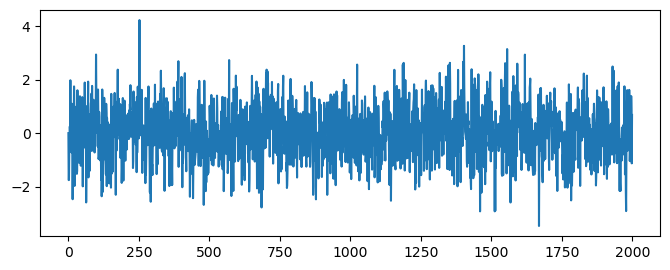

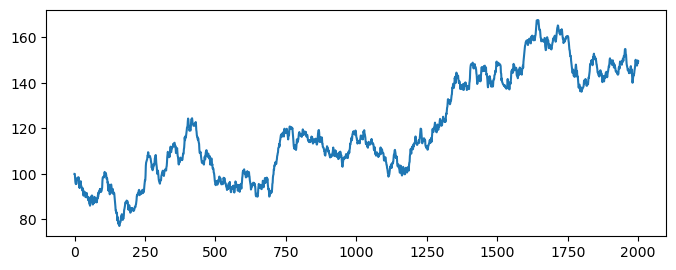

In [3]:
plot0 = plt.figure(0,figsize=(8,3), dpi=100)
plt.plot(delta_y)
plot1 = plt.figure(1,figsize=(8,3), dpi=100)
plt.plot(y)

In [4]:
# to divide 70% for training and 30% for testing
p = .7
div = int(np.round(T*p))
yTrain = y[:div+1]
yTest = y[div+1:]
print(len(yTrain))
print(len(yTest))

delta_yTrain = delta_y[:div]
delta_yTest = delta_y[div:]
print(len(delta_yTrain))
print(len(delta_yTest))

1401
600
1400
600


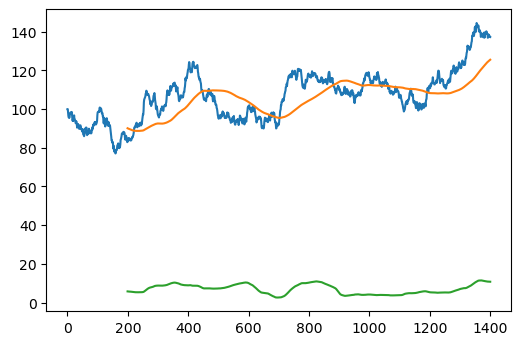

<Figure size 600x400 with 0 Axes>

In [5]:
df_y = pd.DataFrame(yTrain)
rolmean = df_y.rolling(window = 200).mean() #literal es moving average y moving std
rolstd = df_y.rolling(window = 200).std()

plot0 = plt.figure(0,figsize=(6,4), dpi=100)
plt.plot(t[:len(yTrain)],yTrain)
plt.plot(rolmean)
plt.plot(rolstd)

plot1 = plt.figure(1,figsize=(6,4), dpi=100)

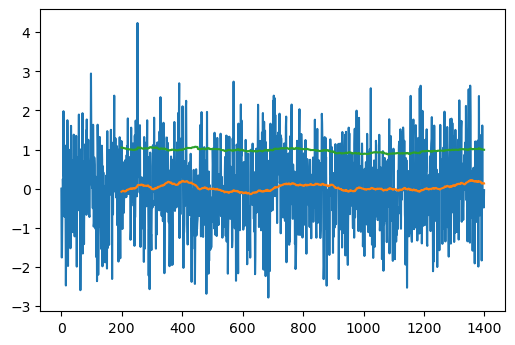

In [6]:
df_deltay = pd.DataFrame(delta_yTrain)
rolmean = df_deltay.rolling(window = 200).mean() #literal es moving average y moving std
rolstd = df_deltay.rolling(window = 200).std()

plot0 = plt.figure(0,figsize=(6,4), dpi=100)
plt.plot(delta_yTrain)
plt.plot(rolmean)
plt.plot(rolstd)

In [9]:
# Perform Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(yTrain, autolag="AIC") # Estamos haciendo Dickey Fuller con criterio de Akaique o como se escriba
dfoutput = pd.Series(dftest[0:4], index=["Test Statistic","p-value","#Lags Used","Number of observations Used"])

for key, value in dftest[4].items():
    dfoutput["Critical Value (%s)"%key] = value
    
print(dfoutput)

Test Statistic                   -1.137429
p-value                           0.699917
#Lags Used                        5.000000
Number of observations Used    1395.000000
Critical Value (1%)              -3.435046
Critical Value (5%)              -2.863614
Critical Value (10%)             -2.567874
dtype: float64


In [10]:
# Perform Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(delta_yTrain, autolag="AIC") # Estamos haciendo Dickey Fuller con criterio de Akaique o como se escriba
dfoutput = pd.Series(dftest[0:4], index=["Test Statistic","p-value","#Lags Used","Number of observations Used"])

for key, value in dftest[4].items():
    dfoutput["Critical Value (%s)"%key] = value
    
print(dfoutput)

#We can see that p-value is low, so we dont reject the null that the time series is not stationary

Test Statistic                -1.757393e+01
p-value                        4.038518e-30
#Lags Used                     3.000000e+00
Number of observations Used    1.396000e+03
Critical Value (1%)           -3.435043e+00
Critical Value (5%)           -2.863613e+00
Critical Value (10%)          -2.567873e+00
dtype: float64


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


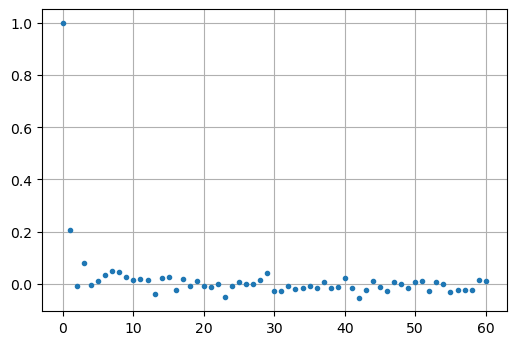

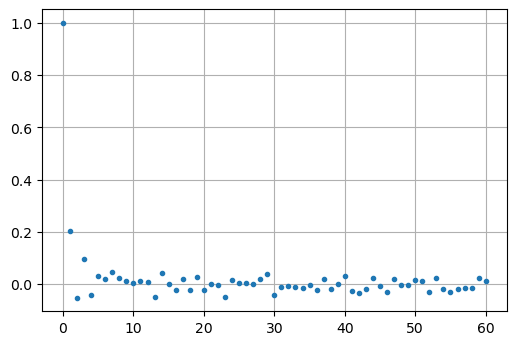

In [115]:
# ACF and PACD
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(delta_yTrain, nlags=60)
lag_pacf = pacf(delta_yTrain, nlags=60, method="ols") # Ordinary least square method

plot0 = plt.figure(0,figsize=(6,4), dpi=100)
plt.plot(lag_acf,".")
plt.grid()

plot1 = plt.figure(1,figsize=(6,4), dpi=100)
plt.plot(lag_pacf,".")
plt.grid()

Text(0.5, 1.0, 'RSS: 1288.4092')

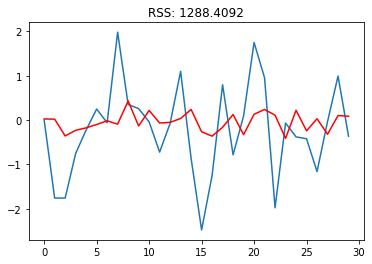

In [116]:
#p and q are both 2 because it is when it reaches below zero
from statsmodels.tsa.arima_model import ARIMA
#import statsmodels.api as sm

#ARIMA model
model = ARIMA(yTrain, order=(2,1,2)) #ellos usaron log y
results_ARIMA = model.fit()
plt.plot(delta_y[:30])
plt.plot(results_ARIMA.fittedvalues[:30], color="red")
plt.title("RSS: %.4f"% sum((results_ARIMA.fittedvalues-delta_yTrain)**2))

In [117]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

0    0.025972
1    0.020677
2   -0.357906
3   -0.230662
4   -0.174769
dtype: float64

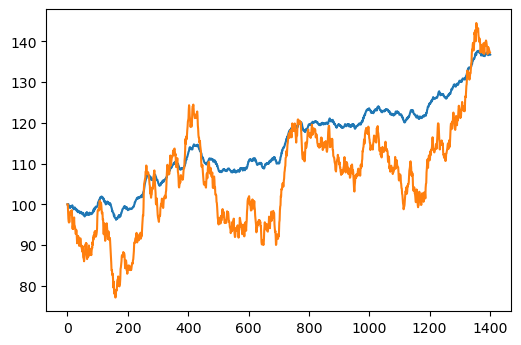

In [118]:
# Creo que esto no sirve
y_predict = np.zeros(len(yTrain)+1)
y_predict[0] = 100
y_predict[1] = 100

for i in range(2,len(yTrain)+1):
    y_predict[i] = y_predict[i-1]+predictions_ARIMA_diff[i-2]

plot1 = plt.figure(1,figsize=(6,4), dpi=100)
plt.plot(y_predict)
plt.plot(yTrain)

# La neta no se porque se ve tan ojete

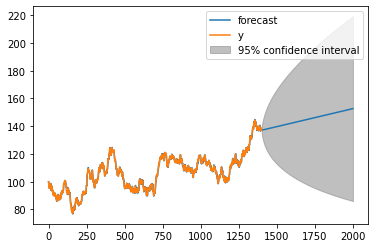

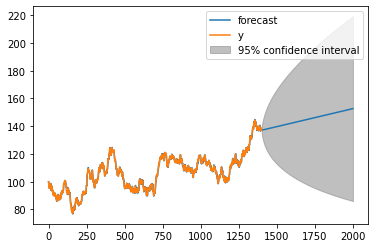

In [119]:
results_ARIMA.plot_predict(1,2000)

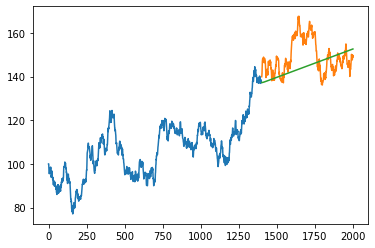

In [120]:
predictions = results_ARIMA.forecast(steps= 600)

plt.plot(t[:1401],yTrain)
plt.plot(t[1401:],yTest)
plt.plot(t[1401:],predictions[0])


In [121]:
# ARIMA TRADING
# No deberia ir un lag atras el prediction??

acum = [0]
acum[0] = 0

w = np.zeros(len(yTest))
cash = np.zeros(len(yTest))

cash[0] = 10000

for i in range(len(yTest)-2):
    if predictions[0][i+1] == yTest[i]: # you do nothing
        w[i+1] = w[i]
        cash[i+1] = cash[i]
    
    if predictions[0][i+1] < yTest[i]: #vendes      
        w[i+1] = 0
        cash[i+1] = w[i]*yTest[i] + cash[i]
        
    if predictions[0][i+1] > yTest[i]: # compras
        cash[i+1] = 0
        w[i+1] = cash[i]/yTest[i]  + w[i] # es el numero de acciones que tienes

#ma[i+1] = y[len(y)-1]

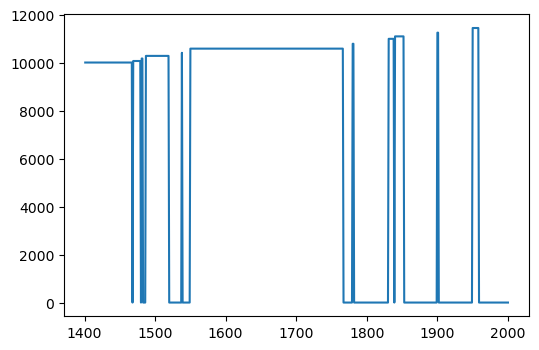

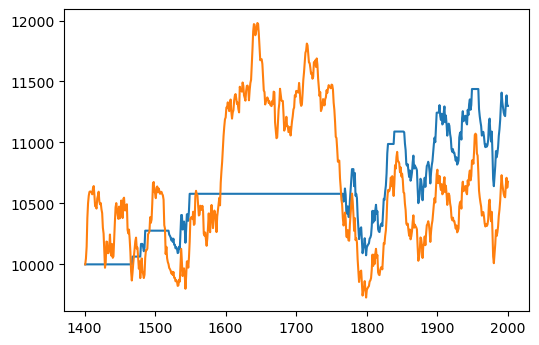

In [122]:
plot4 = plt.figure(4,figsize=(6,4), dpi=100)
plt.plot(t[1401:],cash)

strategy = [a*b for a,b in zip(w,yTest)]+ cash # No entendiste bien estoooo
strategy[599] = strategy[598]

plot5 = plt.figure(5,figsize=(6,4), dpi=100)
plt.plot(t[1401:], strategy)
plt.plot(t[1401:], cash[0]*yTest/yTest[0])

In [123]:
%precision %.2f
# What is the total return of my strategy? 
(strategy[-1]-strategy[0])/strategy[0]

0.12999467320511704

In [124]:
%precision %.2f
# What if I bought all the stocks I could on the first day and I kept them for the whole trading period?
(y[-1]-y[1400])/y[1400] # Importantiiii

0.08855228832373342

(array([  1.,   0.,   1.,   0.,   2.,   5.,   0.,   6.,   6.,   6.,  12.,
         10.,  11.,  15.,  12.,  16., 377.,  19.,  17.,  14.,  14.,  11.,
         12.,   9.,   6.,   8.,   4.,   2.,   2.,   1.]),
 array([-0.02052187, -0.01926522, -0.01800857, -0.01675192, -0.01549527,
        -0.01423862, -0.01298197, -0.01172532, -0.01046867, -0.00921202,
        -0.00795537, -0.00669872, -0.00544207, -0.00418542, -0.00292877,
        -0.00167212, -0.00041547,  0.00084118,  0.00209783,  0.00335448,
         0.00461113,  0.00586778,  0.00712443,  0.00838108,  0.00963773,
         0.01089438,  0.01215103,  0.01340768,  0.01466433,  0.01592097,
         0.01717762]),
 <a list of 30 Patch objects>)

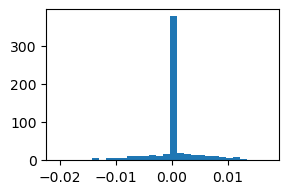

In [125]:
log_returns = np.zeros(len(yTest)-1)
for i in range(len(yTest)-1):
    a = float(strategy[i])
    b = float(strategy[i+1])
    log_returns[i] = np.log(b/a)
plot0 = plt.figure(0,figsize=(3,2), dpi=100)    
plt.hist(log_returns, bins = 30)

In [126]:
alpha = .95
sharp = log_returns.mean()/log_returns.std()
Var = np.quantile(log_returns,1-alpha)
es=np.mean([[v]  for v in log_returns if v < Var])
conditional_sharp = log_returns.mean()/es

print("Performance Indicators of Trend Following Trading Strategy")
print("Sharp Ratio        = ",sharp)
print("Value at Risk      = ",Var)
print("Expected Shortfall = ",es)
print("Conditional Sharp = ",conditional_sharp)

Performance Indicators of Trend Following Trading Strategy
Sharp Ratio        =  0.04622574826094132
Value at Risk      =  -0.007660710068052259
Expected Shortfall =  -0.011253100952525715
Conditional Sharp =  -0.01813084640651222
